## Imports

In [104]:
import copy
import numpy as np
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
from lime.lime_tabular import LimeTabularExplainer
import shap
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

# Problem description

Problem:

$$y = x_1 + x_2 + 100 +\epsilon$$

where $\epsilon \sim N(0,0.01)$. 


Can make $x_3$ dependent on $x_1$. The depedence is defined in the following way:

\begin{align*}
 x_1 &\sim Unif(-10,10) \\
 x_3 &\sim Unif(-10,10) \\
 x_3 &= \text{dep}\cdot x_1 + (1-\text{dep})\cdot x_3
\end{align*}

# Batch size and parameters

In [105]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
n_samples = config['n_samples']
lr = config['lr']
class_problem = config["class_problem"]
non_lin = config["non_lin"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




# Define BATCH sizes
BATCH_SIZE = int((n_samples*0.8)/100)
TEST_BATCH_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n_samples*0.80)/100)
TEST_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

print(NUM_BATCHES)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

1.0


# ReLU based network

## Seperate a test set for later

In [106]:
# Get linear data
y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=class_problem)

n, p = X.shape  # need this to get p 
print(n,p,dim)

# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

40000 4 50


In [107]:
test_dat[20]

tensor([-5.6147,  4.0261,  2.3205, -3.5014,  0.0000])

In [108]:
X_test[20]

array([-5.6147278 ,  4.02607106,  2.32049896, -3.50141904])

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu_lime_comp", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

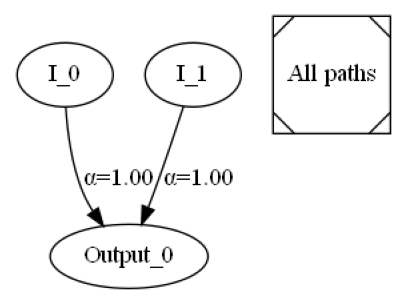

In [110]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_relu_lime_comp.png")
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 2 weights used in median model $\rightarrow$ density of 0.79% compared to initialized model (254 inital weigths) 
* ACC of 99\% for median model
* ACC of 99\% for full model

## Weight graph

In [111]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu_lime_comp", show=False)

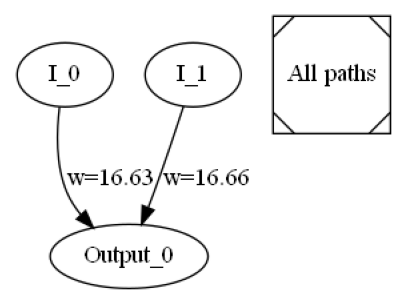

In [112]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu_lime_comp.png")
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### Lime code

In [113]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_lime(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    if len(x.shape) == 1:
        preds = np.zeros((1000, 1, 2))
    else:
        preds = np.zeros((1000, len(x), 2))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 1] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
            preds[samp, :, 0] = 1 - preds[samp, :, 1]
    preds = preds.mean(0)
    return preds

def explain_lime(indx, X_test, feature_names=["x0", "x1", "x2", "x3"], class_names=["Class 0", "Class 1"]):
    # Assuming `X_train` is your training data and `class_names` are the names of the classes
    explainer = LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    # Explain a single instance
    exp = explainer.explain_instance(
        data_row=X_test[indx],
        predict_fn=batch_predict_lime,
        num_features=4,  # Number of features to include in the explanation
        num_samples=10_000
    )
    return exp


def plot_lime_explain(exp, indx, class_label=1, names_features=["x0", "x1", "x2", "x3"]):
    # Extract feature importances for a specific class
    feature_importances = dict(exp.as_map()[class_label])

    # Ensure the feature importances are in the correct order
    ordered_importances = [feature_importances[indx] for indx in range(len(names_features))]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(names_features, ordered_importances, color='skyblue', edgecolor='k')
    plt.ylabel('LIME importance')
    plt.xlabel('Feature')
    plt.title(f'LIME feature importances for Class {class_label} (instance {indx})')
    plt.grid()
    plt.show()

### SHAP code

In [114]:
# Assuming `net` is your trained PyTorch model and `DEVICE` is your computation device (e.g., 'cpu' or 'cuda')

def batch_predict_shap(x):
    net.eval()
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    preds = np.zeros((1000, len(x), 1))
    with torch.no_grad():
        for samp in range(len(preds)):
            preds[samp, :, 0] = net.forward(x, ensemble=False, sample=True).detach().cpu().numpy().T[0]
    preds = preds.mean(0)
    return preds


def shap_explain(X_test, i):
    # Create SHAP explainer
    explainer = shap.Explainer(batch_predict_shap, X_train)
    # Index of the instance you want to explain

    # Explain the instance
    shap_vals = explainer(X_test[i:i+1], max_evals=100_000, batch_size=1000)
    return shap_vals

def plot_shap_explain(shap_vals, i, feature_names = ["x0", "x1", "x2", "x3"]):
    # Plot bar plot of SHAP values
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, shap_vals.values[0], color='skyblue', edgecolor='k')
    plt.xlabel('Feature')
    plt.ylabel('SHAP value')
    plt.title(f'SHAP values for instance {i}. Baseline: {shap_vals.base_values[0][0]:.4f}')
    plt.grid()
    plt.show()

### Positiv prediction

#### Empirical approach

True class: 1.0


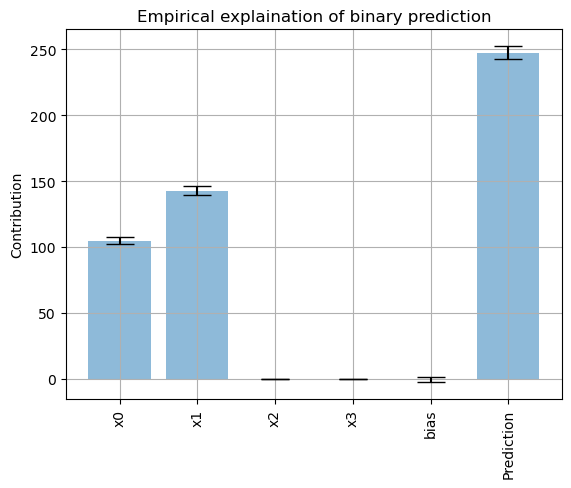

In [115]:
i = 13
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=2_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"])

#### Lime explanation

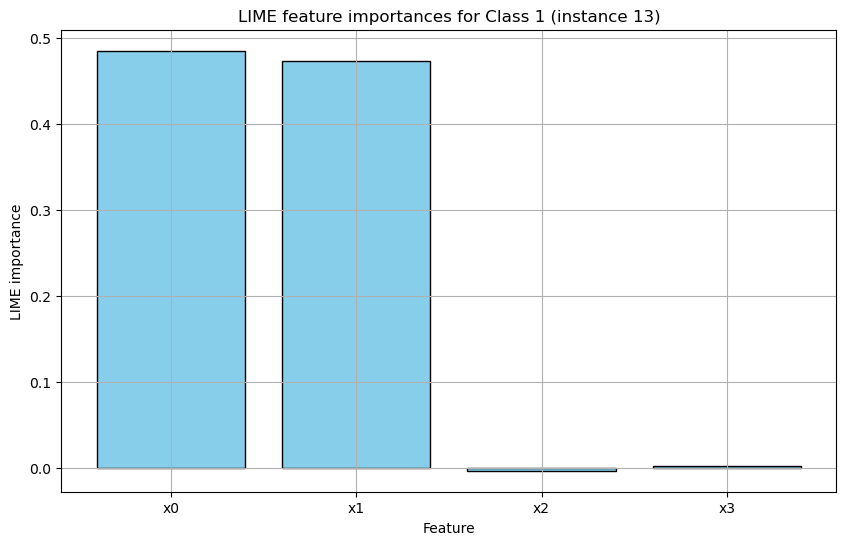

In [116]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [117]:
exp.local_exp

{1: [(0, 0.4852475421596573),
  (1, 0.47319787387385404),
  (3, 0.0030009573651009138),
  (2, -0.0029113624742779115)]}

In [118]:
exp.local_pred

array([1.21961154])

#### Shap explanation

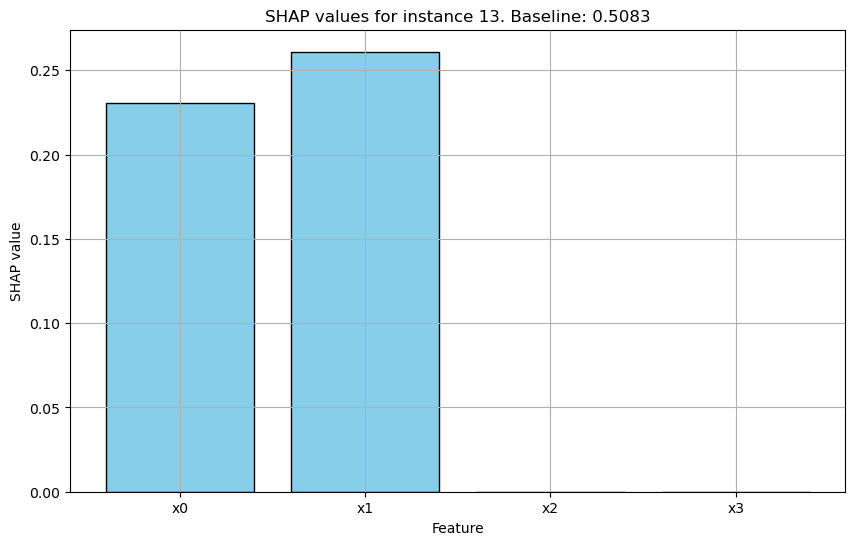

In [119]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

### Negative prediction

#### Empirical approach

True class: 0.0


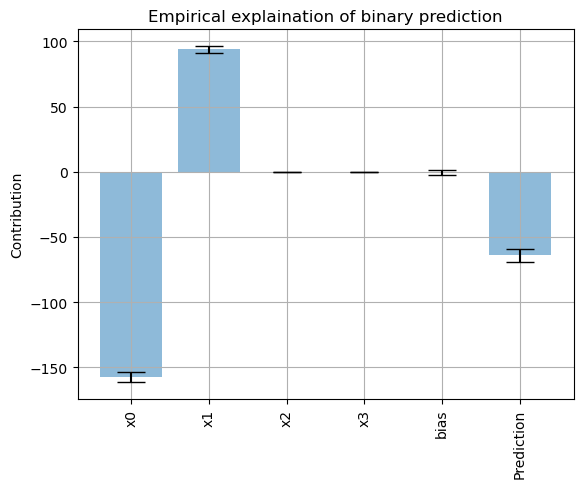

In [120]:
i = 19
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"])

#### LIME explanation

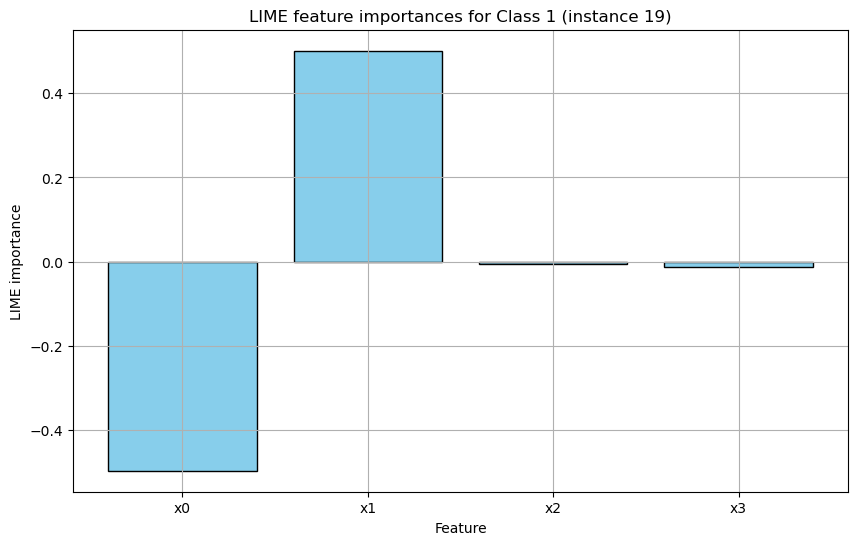

In [121]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

In [122]:
exp.local_exp

{1: [(1, 0.5014145197418869),
  (0, -0.4975124540537483),
  (3, -0.012679646872077947),
  (2, -0.0049411182669959215)]}

#### SHAP explanation

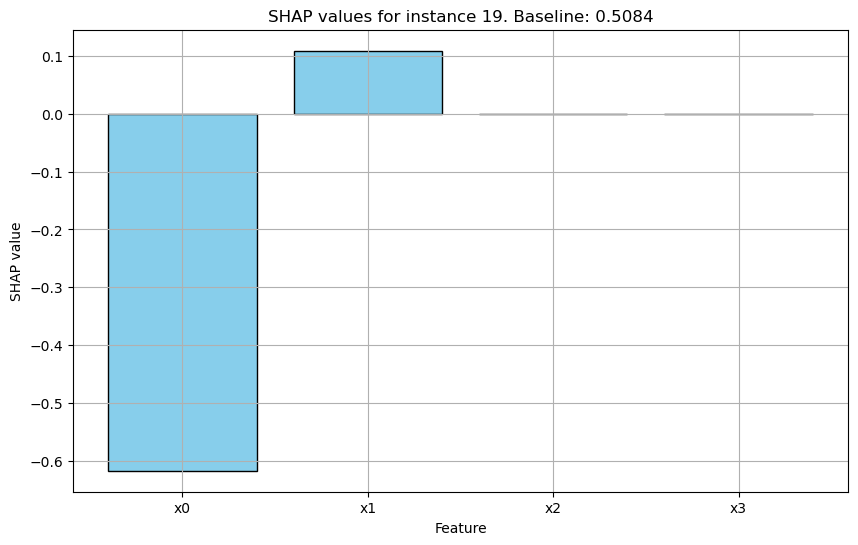

In [123]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [124]:
shap_vals

.values =
array([[-0.61756885,  0.10917454,  0.        ,  0.        ]])

.base_values =
array([[0.50839431]])

.data =
array([[-9.46253363,  5.62874351,  0.89623384, -1.13471563]])

### Very uncertain prediction

#### Empirical explanation

In [125]:
for i in range(100):
    print(i)
    print(test_dat[i,:-1].reshape(-1, p))

0
tensor([[-5.6512,  5.8407, -8.6422, -3.0934]])
1
tensor([[-6.4422, -1.7566,  8.8675,  9.7933]])
2
tensor([[ 1.6291,  8.0236,  2.2779, -2.6108]])
3
tensor([[-3.9306, -2.7232,  3.7955, -6.6712]])
4
tensor([[-4.4139, -2.1120, -1.4629,  9.8541]])
5
tensor([[-4.6606, -4.8004, -3.2201,  7.8726]])
6
tensor([[-1.2486, -7.7578, -2.3293, -0.8516]])
7
tensor([[ 8.6277,  0.4095, -6.6370,  6.6566]])
8
tensor([[-1.2890,  2.2267,  8.5374,  2.7049]])
9
tensor([[-3.8284, -1.9212, -3.8382,  6.2517]])
10
tensor([[ 2.1324,  1.9496, -5.7321, -5.5756]])
11
tensor([[-1.5025, -8.4182,  4.7247, -1.2540]])
12
tensor([[-8.3741,  0.3806,  9.8682,  3.8852]])
13
tensor([[ 6.3087,  8.5670,  4.7858, -2.1504]])
14
tensor([[ 4.0575,  5.4056, -6.8562, -2.8469]])
15
tensor([[ 8.9648,  5.2017, -9.5815,  8.8273]])
16
tensor([[7.5214, 6.1092, 6.9542, 6.0171]])
17
tensor([[ 8.2118,  4.2238,  1.3787, -1.8810]])
18
tensor([[-6.0316,  0.8708, -7.0437, -0.7868]])
19
tensor([[-9.4625,  5.6287,  0.8962, -1.1347]])
20
tensor([[-5

True class: 1.0


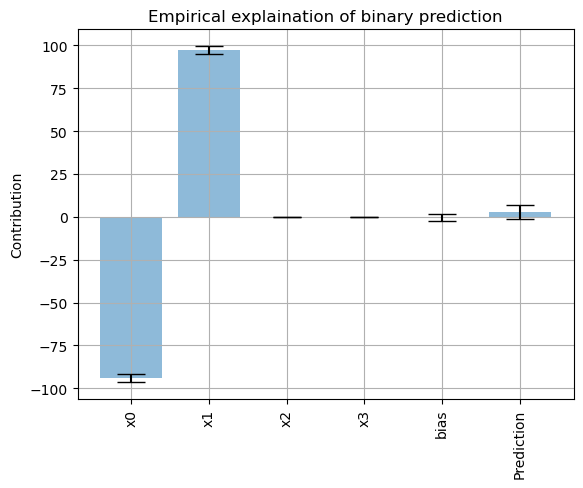

In [140]:
i = 0
explain_this = test_dat[i,:-1].reshape(-1, p)
print(f"True class: {test_dat[i,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, variable_names=["x0", "x1", "x2", "x3"], class_names=["binary prediction"])

#### LIME explanation

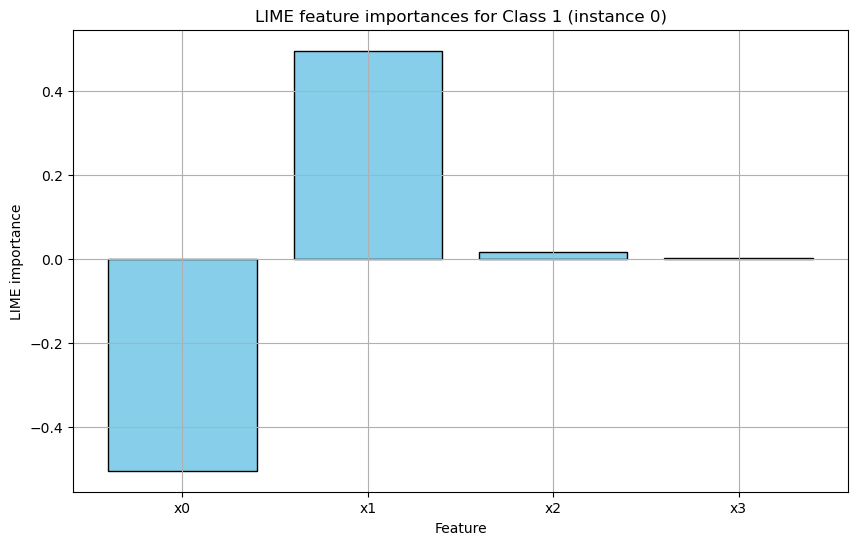

In [141]:
exp = explain_lime(i, X_test)
plot_lime_explain(exp, i)

#### SHAP explanation

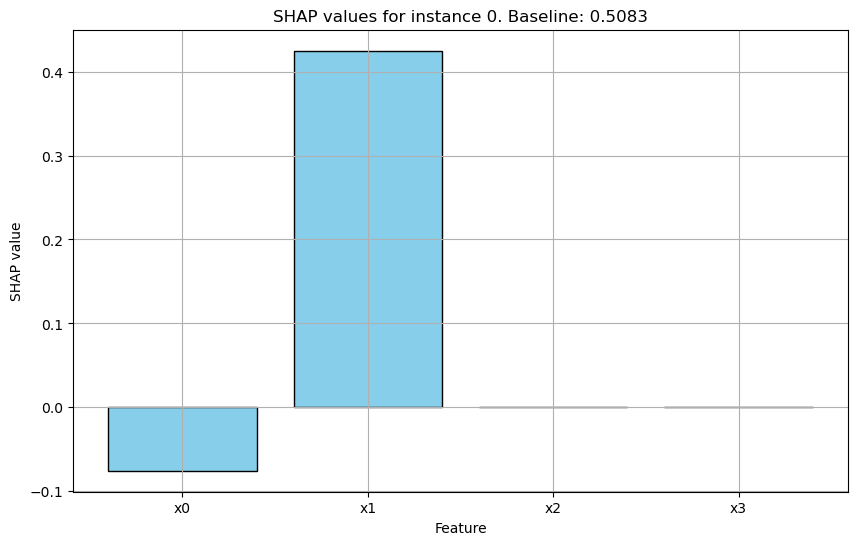

In [142]:
shap_vals = shap_explain(X_test, i)
plot_shap_explain(shap_vals, i)

In [143]:
shap_vals.values

array([[-7.55086067e-02,  4.24919136e-01,  2.77555756e-17,
         0.00000000e+00]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


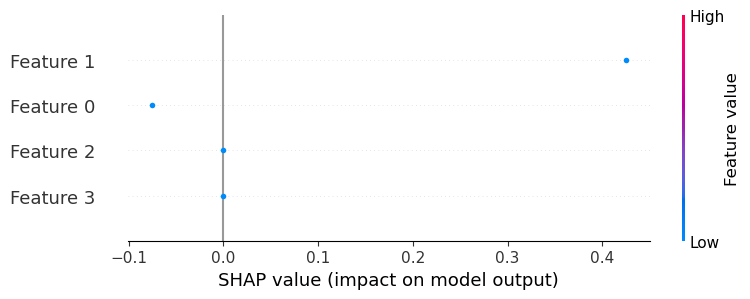

In [144]:
shap.summary_plot(shap_vals, X_test[i:i+1])

In [145]:
shap_vals

.values =
array([[-7.55086067e-02,  4.24919136e-01,  2.77555756e-17,
         0.00000000e+00]])

.base_values =
array([[0.50830087]])

.data =
array([[-5.65123202,  5.84074048, -8.64222981, -3.09339411]])